In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import torch
from torch import nn
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
from datasets import load_dataset

c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import BeitFeatureExtractor

feature_extractor = BeitFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
train_ds = load_dataset("DGE_training_mixed", data_dir="*/", split="train")
val_ds = load_dataset("DGE_val_mixed", data_dir="*/", split="train")
test_ds = load_dataset("DGE_test_mixed", data_dir="*/", split="train")

Resolving data files: 100%|██████████| 3701/3701 [00:00<00:00, 13962.93it/s]
Using custom data configuration DGE_training_mixed-fd742625a6ce5be8
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_training_mixed-fd742625a6ce5be8\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)
Resolving data files: 100%|██████████| 1462/1462 [00:00<00:00, 81205.52it/s]
Using custom data configuration DGE_val_mixed-218f740e80f04e7b
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_val_mixed-218f740e80f04e7b\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)
Resolving data files: 100%|██████████| 777/777 [00:00<00:00, 388389.25it/s]
Using custom data configuration DGE_test_mixed-f694dbbba38ea020
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_test_mixed-f694dbbba38ea020\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


In [3]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
print(label2id)

{'2': 0, '3': 1, '4': 2, '5': 3, '6': 4}


In [4]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor,
                                    RandomRotation)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [5]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [6]:
from sklearn.utils import class_weight
import pandas as pd
import numpy as np

train_df = pd.read_csv('train_data_mixed.csv',dtype=str)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
print(class_weights)

# dataset_size = len(train_ds[:]['label'])
# train_count = int(dataset_size * 0.7)
# val_count = int(dataset_size - train_count)
y_train = train_ds[:]['label']

#print(train_dataset[0])
import numpy as np 

#y_train_indices = train_dataset["train"].indices

#y_train = train_ds[:]['label']

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

[1.47744511 3.31928251 0.57379845 0.48096166 5.00135135]


In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 32
eval_batch_size = 16

#the index errors are caused by the dataloaders indexing values that are out of bounds!

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=train_batch_size, sampler=sampler)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)#, sampler=sampler)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=train_batch_size)

In [9]:
#print(val_ds['label'][:])
print(len(val_dataloader.dataset))
print(len(pd.read_csv('val_data_mixed.csv',dtype=str)['class']))

1462
1462


In [10]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


In [11]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [12]:
import pytorch_lightning as pl
from transformers import BeitForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224",
                                                              num_labels=5,
                                                              id2label=id2label,
                                                              label2id=label2id,
                                                              ignore_mismatched_sizes=True)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        #criterion = nn.CrossEntropyLoss()
        criterion = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(class_weights))
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", accuracy, on_epoch=True)

        return loss, accuracy

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=1e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader
    
    def test_dataloader(self):
        return test_dataloader
    
    def predict_dataloader(self):
        return test_dataloader

In [13]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=1,
    strict=False,
    verbose=True,
    mode='min',
    check_on_train_epoch_end=True
)

checkpoint = ModelCheckpoint(dirpath='VIT_models\\', filename='{epoch}-{validation_loss:.2f}-{validation_accuracy:.2f}', monitor='validation_loss', save_top_k=2)

model = ViTLightningModule()
trainer = Trainer(accelerator='gpu', devices=1, callbacks=[early_stop_callback, checkpoint],
    check_val_every_n_epoch=1, 
    max_epochs=100,
    #min_epochs=1,
    )

trainer.fit(model)

c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using:

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 208/208 [00:45<00:00,  4.61it/s, loss=0.29, v_num=58] 

Metric validation_loss improved. New best score: 2.789


Epoch 1: 100%|██████████| 208/208 [00:43<00:00,  4.75it/s, loss=0.169, v_num=58]

Monitored metric validation_loss did not improve in the last 1 records. Best score: 2.789. Signaling Trainer to stop.


Epoch 1: 100%|██████████| 208/208 [00:46<00:00,  4.43it/s, loss=0.169, v_num=58]


In [14]:
trainer.test(model=model, dataloaders=test_dataloader, verbose=True)

#trainer.test(model=model, dataloaders=val_dataloader, verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:  92%|█████████▏| 23/25 [00:03<00:00,  7.21it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
#return

In [ ]:
y_pred = []
y_true = []
model.to('cuda')
model.eval()
for batch in test_dataloader:
    labels = batch['labels'].to('cuda')
    outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'))
    predictions=np.argmax(outputs.cpu().detach().numpy(), axis=-1)
    y_pred.append(predictions)
    y_true.append(labels.cpu().detach().numpy())
    #metric.add_batch(predictions=predictions, references=labels)

In [ ]:
y_true_total = []
for i in range(np.shape(y_true)[0]):
    for j in range(len(y_true[i])):
        y_true_total.append(y_true[i][j])

y_pred_total = []
for i in range(np.shape(y_pred)[0]):
    for j in range(len(y_pred[i])):
        y_pred_total.append(y_pred[i][j])

print(len(y_pred_total))
print(len(y_true_total))

print(np.shape(y_pred)[0])
print(np.shape(y_true)[0])

624
624
39
39


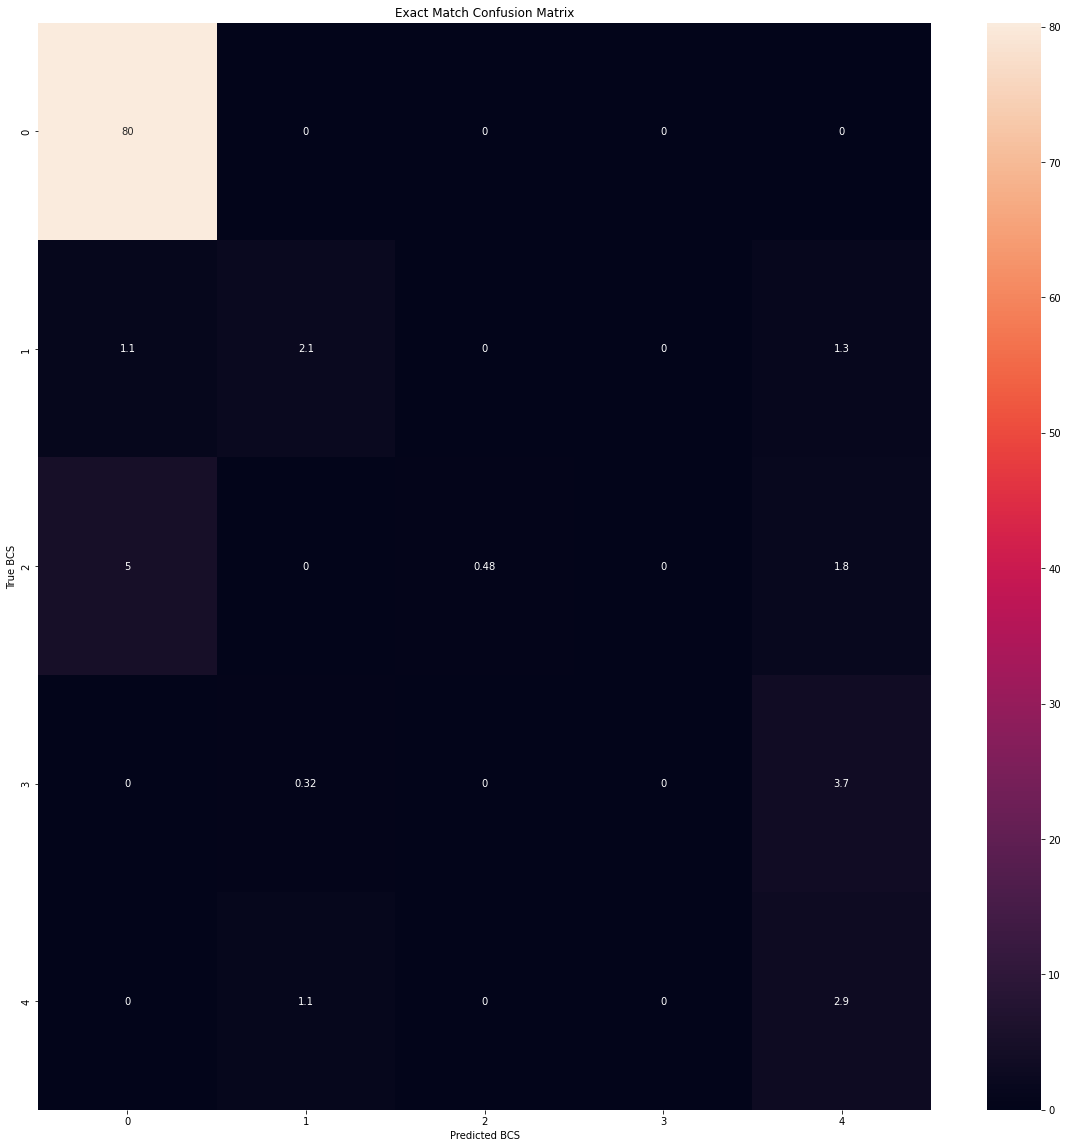

Model accuarcy is:  0.8573717948717948
Model precision is:  0.5640816326530611
Model f1_score is:  0.40639819004524885
Model recall is:  0.4501904761904762
Model MSE is:  0.5464743589743589
Confusion Matrix
[[501   0   0   0   0]
 [  7  13   0   0   8]
 [ 31   0   3   0  11]
 [  0   2   0   0  23]
 [  0   7   0   0  18]]


c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn.metrics


cf_matrix = confusion_matrix(y_true_total, y_pred_total)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = range(0, 5),
                     columns = range(0, 5))


plt.figure(figsize=(20,20))
sn.heatmap(df_cm, annot=True)
#sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true_total, y_pred_total, display_labels=[2, 3, 4, 5, 6], cmap='gray', colorbar=False)
plt.title('Exact Match Confusion Matrix')
plt.xlabel('Predicted BCS')
plt.ylabel('True BCS')
plt.show()
# plt.xticks([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])
# plt.yticks([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])



import sklearn
#metrics
accuarcy = sklearn.metrics.accuracy_score(y_true_total, y_pred_total)
print('Model accuarcy is: ', accuarcy)
precision = sklearn.metrics.precision_score(y_true_total,y_pred_total, average='macro')
print('Model precision is: ', precision)

f1_score = sklearn.metrics.f1_score(y_true_total,y_pred_total, average='macro')
print('Model f1_score is: ', f1_score)

recall = sklearn.metrics.recall_score(y_true_total,y_pred_total, average='macro')
print('Model recall is: ', recall)

MSE = sklearn.metrics.mean_squared_error(y_true_total,y_pred_total)
print('Model MSE is: ', MSE)

print("Confusion Matrix")
print(cf_matrix)

The accuracy of the network model2 is:  0.905448717948718
Model unweighted precision is:  0.8235741964417101
Model weighted precision is:  0.9187161826397306

Model unweighted recall is:  0.6841904761904762
Model weighted recall is:  0.905448717948718

Model unweighted f1_score is:  0.6671446400092915
Model weighted f1_score is:  0.8809514987516212

Confusion Matrix
[[501   0   0   0   0]
 [  0  20   0   0   8]
 [ 31   0   3   0  11]
 [  0   2   0  23   0]
 [  0   7   0   0  18]]


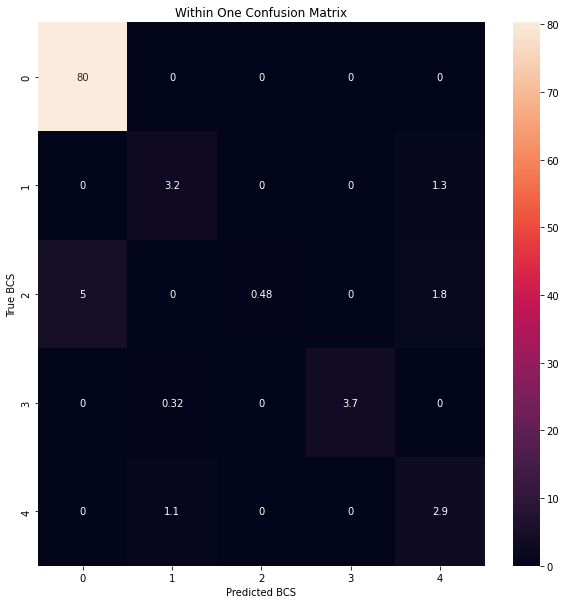

In [ ]:
y_within_1 = []
for i in range(0, len(y_true_total)):
    if ((y_pred_total[i] == y_true_total[i]+1) or (y_pred_total[i] == y_true_total[i]-1) or (y_pred_total[i] == y_true_total[i])):
        y_within_1.append(y_true_total[i])
    else:
        y_within_1.append(y_pred_total[i])

# print(y_within_1)
# print(type(y_within_1[20]))
# print(type(y_true_total[0]))


cf_matrix = confusion_matrix(y_true_total, y_within_1)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = range(0, 5),
                     columns = range(0, 5))


plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True)
plt.title('Within One Confusion Matrix')
plt.xlabel('Predicted BCS')
plt.ylabel('True BCS')


con_matrix = sklearn.metrics.confusion_matrix(y_true_total,y_within_1)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()


print('The accuracy of the network model2 is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

#Metrics
precision = sklearn.metrics.precision_score(y_true_total,y_within_1, average='macro')
print('Model unweighted precision is: ', precision)
precision = sklearn.metrics.precision_score(y_true_total,y_within_1, average='weighted')
print('Model weighted precision is: ', precision)
print()

#print('Avg :', sklearn.metrics.accuracy_score(y_test, y_test_hat, normalize=False))

recall = sklearn.metrics.recall_score(y_true_total,y_within_1, average='macro')
print('Model unweighted recall is: ', recall)
recall = sklearn.metrics.recall_score(y_true_total,y_within_1, average='weighted')
print('Model weighted recall is: ', recall)
print()

f1_score = sklearn.metrics.f1_score(y_true_total,y_within_1, average='macro')
print('Model unweighted f1_score is: ', f1_score)
f1_score = sklearn.metrics.f1_score(y_true_total,y_within_1, average='weighted')
print('Model weighted f1_score is: ', f1_score)
print()


print("Confusion Matrix")
print(con_matrix)

In [ ]:
#torch.save(model, 'VIT_models\BEiT_42.pt')
# torch.save(
#     model.state_dict(),
#     'VIT_models\BEiT_42.pt'
# )

In [ ]:
#trainer.save_checkpoint("VIT_models\BEiT_XX_keep_test.ckpt")

In [ ]:
# new_model = ViTLightningModule.load_from_checkpoint(checkpoint_path="VIT_models\BEiT_42_keep_test.ckpt")
# trainer.test(model=new_model, dataloaders=test_dataloader, verbose=True)